In [1]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import string
import sys

import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(precision=4, suppress=True)

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [2]:
cols = ["userId", "movieId", "rating"]
Rdf = pd.read_csv('C:/Work/UCLA/Winter 2021/219 Large Scale Data Mining Models and Algorithms/Project_3/ml-latest-small/ratings.csv',usecols = cols)
#Rdf = pd.read_csv('C:/Work/UCLA/Winter 2021/219 Large Scale Data Mining Models and Algorithms/Project_3/ml-latest-small/tp.csv',usecols = cols)
R = Rdf.pivot(index = "userId", columns = "movieId", values = "rating")
R.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
R = R.to_numpy()  #R is now the numpy Ratings matrix
m = R.shape[0]      #m is the number of users
n = R.shape[1]      #n is the number of movies

print("Number of users:", m)
print("Number of movies:", n)


Number of users: 610
Number of movies: 9724


## Q1. Sparsity

In [81]:
num_ratings = Rdf.shape[0]
sparsity = num_ratings/(m*n)

print("Sparsity is", sparsity)
print("Num of available ratings = ", num_ratings)
print("Num of possible ratings = ", m*n)


Sparsity is 0.016999683055613623
Num of available ratings =  100836
Num of possible ratings =  5931640


## Q2. Histogram showing frequency of rating values

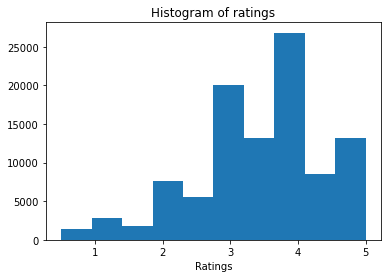

In [82]:
plt.hist(Rdf["rating"], bins = 10)
plt.title("Histogram of ratings")
plt.xlabel("Ratings")
plt.show()

## Q3. Distribution of number of ratings received among movies

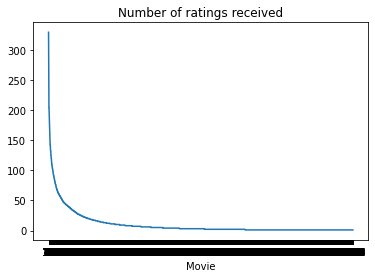

In [83]:
mov = Rdf['movieId'].value_counts()
mov = mov.to_numpy()

plt.plot(np.arange(1,n+1), mov)
plt.xticks(np.arange(1,n+1))
plt.title("Number of ratings received")
plt.xlabel("Movie")
plt.show()

## Q4. Distribution of the number of ratings among users

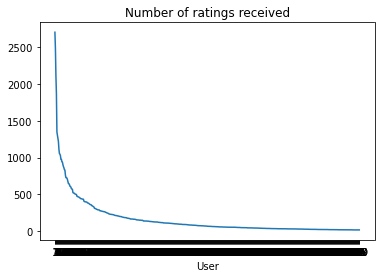

In [84]:
users = Rdf['userId'].value_counts()
users = users.to_numpy()

plt.plot(np.arange(1,m+1), users)
plt.xticks(np.arange(1,m+1))
plt.title("Number of ratings received")
plt.xlabel("User")
plt.show()

## Q5. Features of the ratings distribution

## Q6. Histogram of variance of the rating values received by each movie

Maximum variance is 5.0625
Minimum variance is 0.0


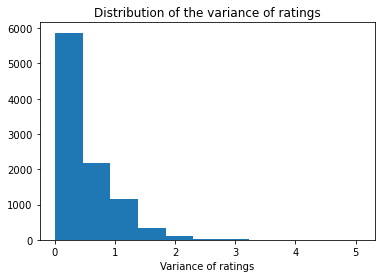

In [85]:
mov_var = Rdf[["movieId","rating"]].groupby(['movieId']).var(ddof=0) #Ref: ddof = 0 makes the divisor used in calculations N-ddof = N
mov_var = mov_var.to_numpy()
mov_var = np.squeeze(mov_var)

print("Maximum variance is", np.max(mov_var))
print("Minimum variance is",np.min(mov_var))
bins = np.ceil((np.max(mov_var) - np.min(mov_var))/0.5)
#print(bins)
plt.hist(mov_var, bins = int(bins))
plt.title("Distribution of the variance of ratings")
plt.xlabel("Variance of ratings")
plt.show()

## Q7. Pearson Correlation Coefficient

<font size="5">$\mu_u = \frac{\Sigma_{k \in I_u}r_{uk}}{size(I_u)}$</font>

## Q8. 

$I_u \cap I_v = \phi$ indicates that there were no common movies rated by both user $u$ and user $v$

## Q9. Mean centering

Since ratings ought to help us compare how much a user liked one movie over the others they watched, mean centered ratings are a better measure for this purpose. This is because mean centering removes the individual bias of users - some users give raw ratings in the higher ranges for all movies, and hence mean centering allows us to conclude that the now positive rated movies are the ones they prefer more than an average movie according to them.

In [86]:
#conda install -c conda-forge scikit-surprise

## Q 10.

In [3]:
from surprise import Reader
from surprise import Dataset
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise import similarities
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import accuracy

In [88]:
reader = Reader(rating_scale=(0.5, 5))
R_data = Dataset.load_from_df(Rdf[["userId", "movieId", "rating"]], reader)

sim_options = {'name': 'pearson',
              'user_based': True}

k_list = np.arange(2,101,2)
scores = []

for k in k_list:
    algo = KNNWithMeans(k = k,sim_options=sim_options, verbose = False)
    pred = cross_validate(algo, R_data, cv = 10, verbose = False, n_jobs = -1)
    rmse = np.mean(pred['test_rmse'])
    rmae = np.mean(pred['test_mae'])
    scores.append([rmse, rmae])
    
scores_df = pd.DataFrame(scores, columns = ['Avg RMSE', 'Avg MAE'], index = k_list)

scores_df

,Avg RMSE,Avg MAE
2,1.018185,0.785315
4,0.945780,0.726422
6,0.919274,0.704402
8,0.907985,0.694670
10,0.900566,0.688128
12,0.898031,0.685315
14,0.895245,0.682683
16,0.892838,0.680807
18,0.893598,0.680957
20,0.891548,0.679053


<AxesSubplot:title={'center':'Cross validation - MAE'}, xlabel='k', ylabel='MAE'>

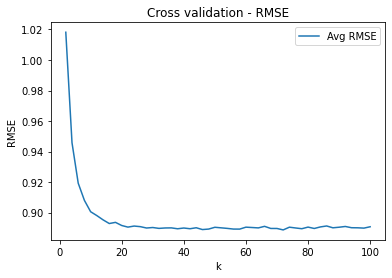

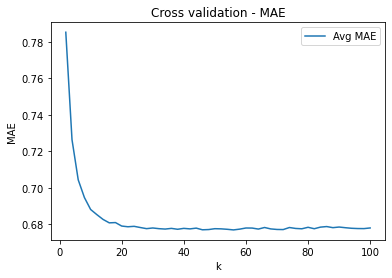

In [89]:
scores_df.plot(y = 'Avg RMSE', xlabel = "k", ylabel = "RMSE", title = "Cross validation - RMSE")
scores_df.plot(y = 'Avg MAE', xlabel = "k", ylabel = "MAE", title = "Cross validation - MAE")

## Q 11.

For RMSE, minimum k = 20, and RMSE(k=20) = 0.891

For MAE, minimum k = 28, and MAE (k=28) = 0.677

## Q 12.

In [4]:
reader = Reader(rating_scale=(0.5, 5))

R_data = Dataset.load_from_df(Rdf[["userId", "movieId", "rating"]], reader)

sim_options = {'name': 'pearson',
              'user_based': True}

In [5]:
def popular_movies(df):
    ts = df.value_counts('movieId') #ts is a series showing number of ratings for each 'movieId'
    movies = ts[ts>2].index #ts[ts>2]'s indices are movieId values satisfying the condition
    trim = df.loc[df['movieId'].isin(movies)]
    trim
    return trim

In [6]:
kf = KFold(n_splits=10)

k_list = np.arange(2,101,2)

scores = []

for k in k_list:
    
    algo = KNNWithMeans(k = k,sim_options=sim_options, verbose = False)
    set_scores = []
    for trainset, testset in kf.split(R_data):
        #trainset and testset are lists made of tuples
        algo.fit(trainset)
        
        test_df = pd.DataFrame(testset, columns = ["userId", "movieId", "rating"])#converting testset into dataframe test_df
        test_df = popular_movies(test_df)
        test_tuples = [tuple(x) for x in test_df.to_numpy()] #converting the trimmed test_df into tuples
        
        predictions = algo.test(test_tuples)

        set_scores.append(accuracy.rmse(predictions, verbose=False))
    
    scores.append(sum(set_scores)/len(set_scores))

Minimum average RMSE is  0.8542364591375305


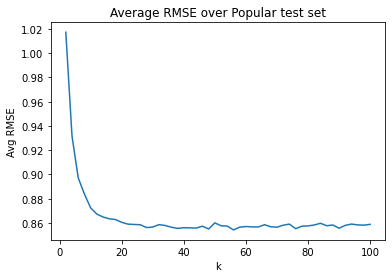

In [7]:
print("Minimum average RMSE is ", min(scores))
plt.plot(k_list, scores)
plt.xlabel('k')
plt.ylabel("Avg RMSE")
plt.title("Average RMSE over Popular test set")
plt.show()

## Q 13. Unpopular movies test sets

In [8]:
def unpopular_movies(df):
    ts = df.value_counts('movieId') #ts is a series showing number of ratings for each 'movieId'
    movies = ts[ts<=2].index #ts[ts>2]'s indices are movieId values satisfying the condition
    trim = df.loc[df['movieId'].isin(movies)]
    trim
    return trim

In [9]:
kf = KFold(n_splits=10)

k_list = np.arange(2,101,2)

scores = []

for k in k_list:
    
    algo = KNNWithMeans(k = k,sim_options=sim_options, verbose = False)
    set_scores = []
    for trainset, testset in kf.split(R_data):
        #trainset and testset are lists made of tuples
        algo.fit(trainset)
        
        test_df = pd.DataFrame(testset, columns = ["userId", "movieId", "rating"])
        test_df = unpopular_movies(test_df)
        test_tuples = [tuple(x) for x in test_df.to_numpy()]
        
        predictions = algo.test(test_tuples)

        set_scores.append(accuracy.rmse(predictions, verbose=False))
    
    scores.append(sum(set_scores)/len(set_scores))

Minimum average RMSE is  0.9530988852354133


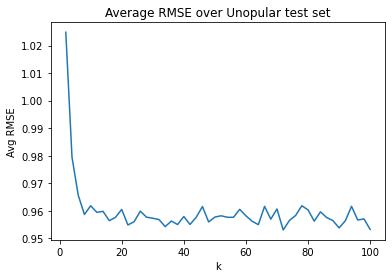

In [10]:
print("Minimum average RMSE is ", min(scores))
plt.plot(k_list, scores)
plt.xlabel('k')
plt.ylabel("Avg RMSE")
plt.title("Average RMSE over Unopular test set")
plt.show()

## Q 14. High variance movie trest sets

In [11]:
def high_variance(df):
    
    #trimmed to contain movies with atleast five ratings.
    ts = df.value_counts('movieId') 
    movies = ts[ts>=5].index
    df = df.loc[df['movieId'].isin(movies)]
    
    #consider movies with variance >=2
    mov_var = df[["movieId","rating"]].groupby(['movieId']).var().rename(columns ={'rating':'variance'})
    movies = mov_var[mov_var['variance'] >= 2].index
    df = df.loc[df['movieId'].isin(movies)]
    return df

In [12]:
kf = KFold(n_splits=10)

k_list = np.arange(2,101,2)

scores = []

for k in k_list:
    
    algo = KNNWithMeans(k = k,sim_options=sim_options, verbose = False)
    set_scores = []
    for trainset, testset in kf.split(R_data):
        #trainset and testset are lists made of tuples
        algo.fit(trainset)
        
        test_df = pd.DataFrame(testset, columns = ["userId", "movieId", "rating"])
        test_df = high_variance(test_df)
        test_tuples = [tuple(x) for x in test_df.to_numpy()]
        
        predictions = algo.test(test_tuples)

        set_scores.append(accuracy.rmse(predictions, verbose=False))
    
    scores.append(sum(set_scores)/len(set_scores))

Minimum average RMSE is  1.297356189327368


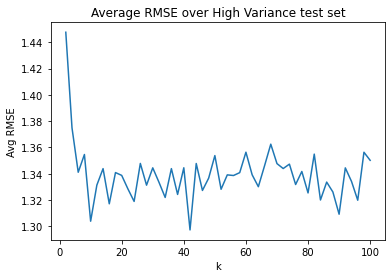

In [13]:
print("Minimum average RMSE is ", min(scores))
plt.plot(k_list, scores)
plt.xlabel('k')
plt.ylabel("Avg RMSE")
plt.title("Average RMSE over High Variance test set")
plt.show()

## Q 15.

In [14]:
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
trainset, testset = train_test_split(R_data, test_size=.10)

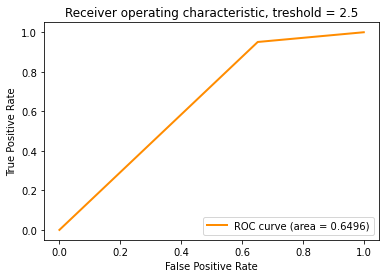

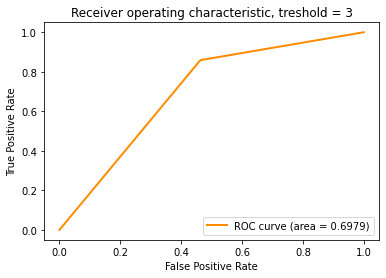

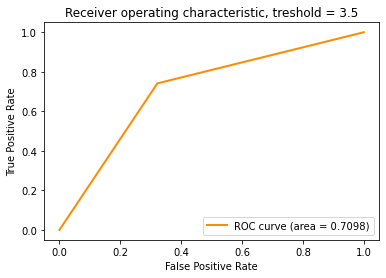

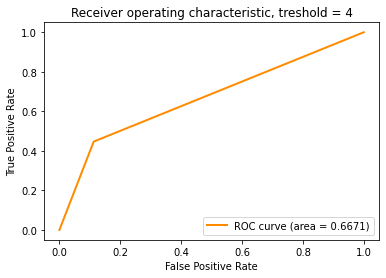

In [15]:
thres_list = [2.5, 3, 3.5, 4]

roc_auc = []

for t in thres_list:
    
    algo = KNNWithMeans(k = 20,sim_options = sim_options, verbose = False)
    algo.fit(trainset)
    preds = algo.test(testset)
    preds = np.asarray(preds)

    true_scores = preds[:,2] >= t #actual scores
    true_scores.astype(int)
    pred_scores = preds[:,3] >= t #predicted scores
    pred_scores.astype(int)
    
    fpr, tpr, _ = roc_curve(true_scores, pred_scores)
    roc_auc.append(auc(fpr, tpr))
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.4f)' % roc_auc[-1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic, treshold = {}'.format(t))
    plt.legend(loc="lower right")
    plt.show()